In [ ]:
!pip install plotly
!pip install scikit-learn==1.2.1

In [1]:
from os.path import join

import numpy as np
import pandas as pd
import dask.dataframe as dd
import xgboost as xgb

In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_simple_norm_parquet'
CKPT_PATH = '/mnt/dssfs02/xgboost_ckpts/model6.json'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Load model

In [4]:
clf = xgb.XGBClassifier()
clf.load_model(CKPT_PATH)
clf

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=20, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, ...)

In [5]:
x_test = np.load(join(DATA_PATH, 'pca/x_pca_training_test_split_256.npy'))

# Classification performance

In [6]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from utils import correct_labels

In [7]:
y_pred = clf.predict(x_test)

In [8]:
assert y_pred.shape[0] == y_true.shape[0]

#### Overall performance

In [9]:
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

In [10]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.829941,0.829941,0.829941,8.299414e-01
macro avg,0.683445,0.704106,0.679380,1.403904e+06
weighted avg,0.838224,0.829941,0.827728,1.403904e+06


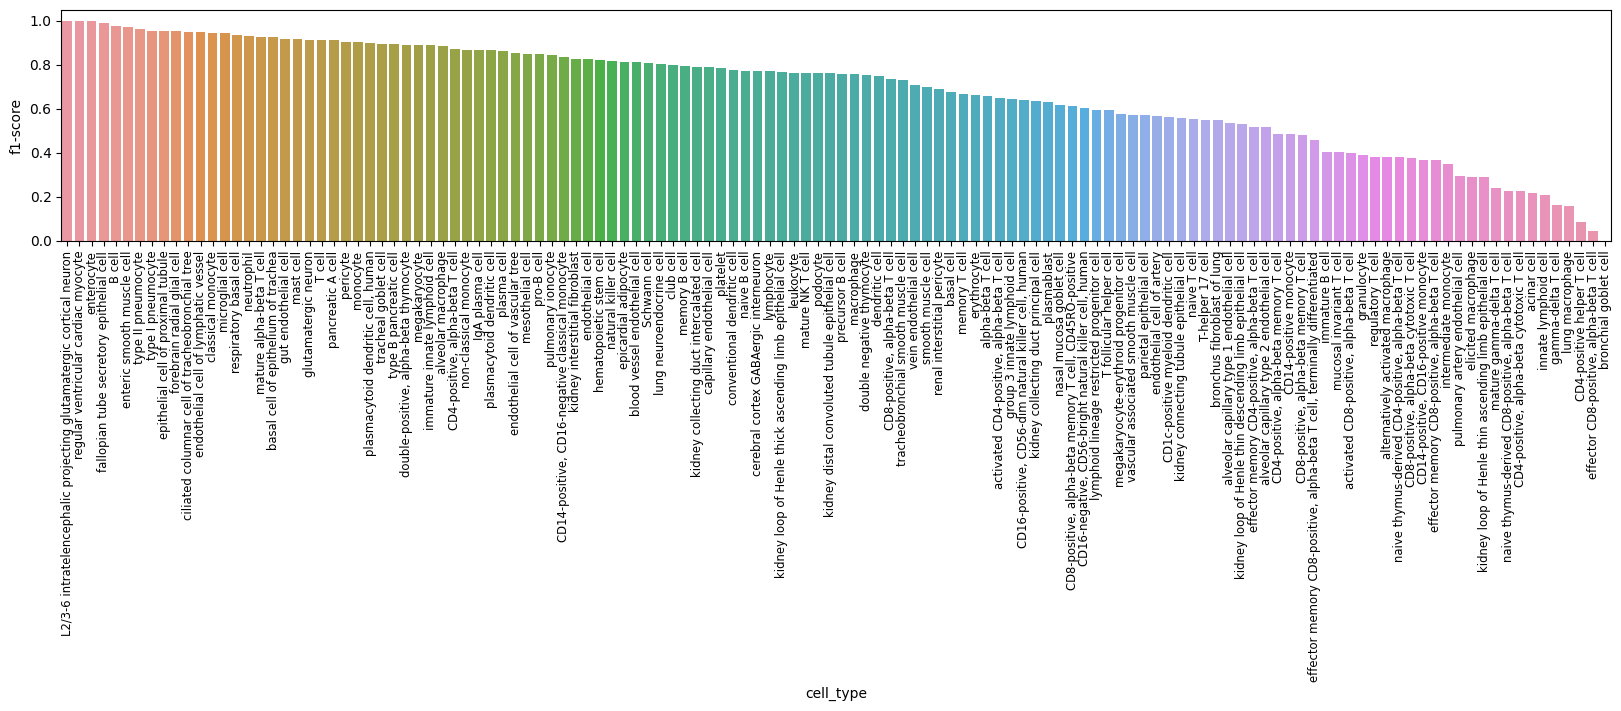

In [11]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_tick_params(labelsize='small');

#### Confustion matrix

In [12]:
c_matrix = confusion_matrix(y_true, y_pred_corr, normalize='true')

In [ ]:
px.imshow(
    c_matrix, 
    width=1000, height=1000,
    labels={'x': 'Predicted Label', 'y': 'True Label'},
    x=cell_type_mapping.label.tolist(), y=cell_type_mapping.label.tolist()
)

# Visualize predictions

In [ ]:
!pip install scanpy

In [13]:
import anndata
import scanpy as sc

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## predictions vs true labels

Plot TSNE embedding (based on 64 PCA components of the input features) and super-impose true labels and predicted labels

In [14]:
adata = anndata.AnnData(
    X=np.load(join(DATA_PATH, 'pca/x_pca_test_50.npy')), 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten()
    })
)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
sc.pp.subsample(adata, n_obs=200_000)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.tsne(adata, use_rep='X')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


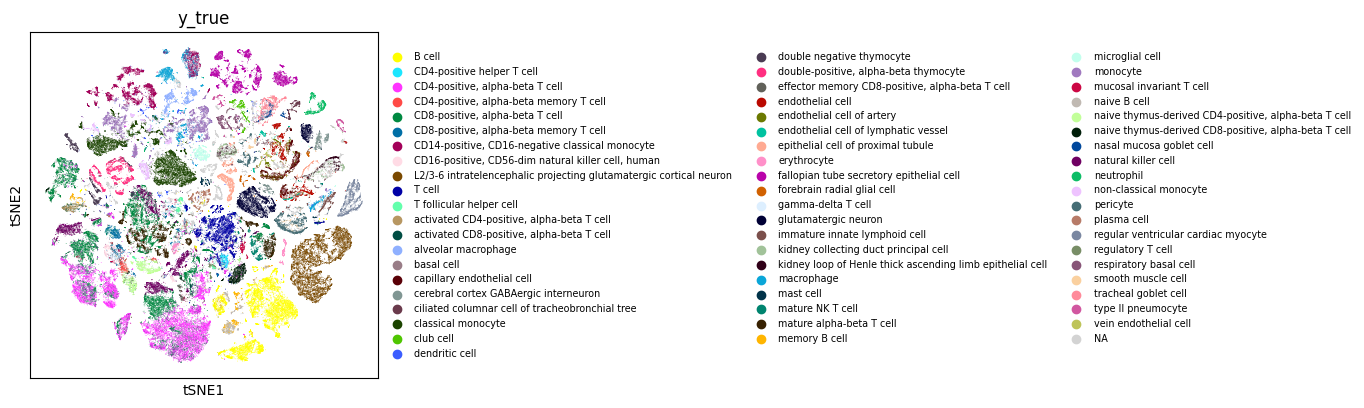

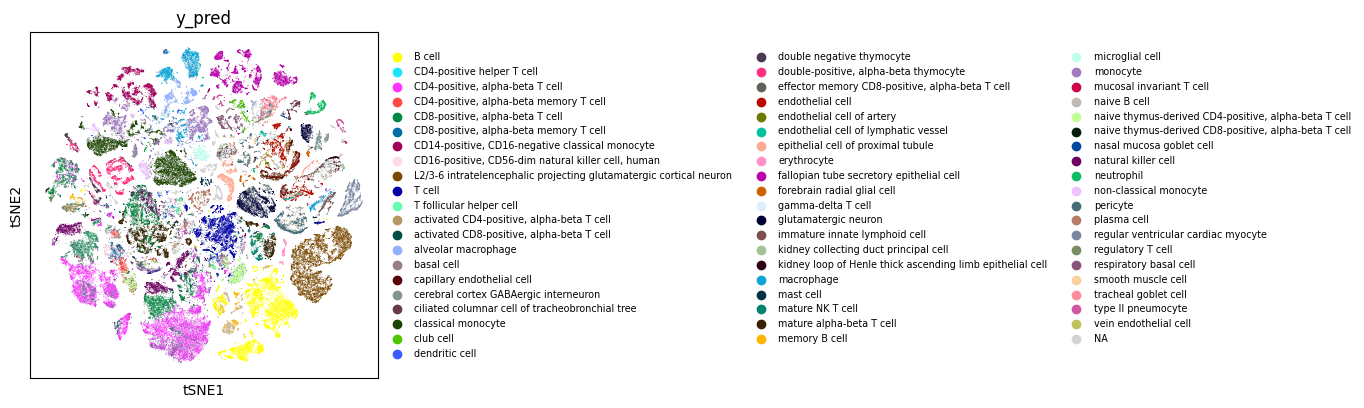

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


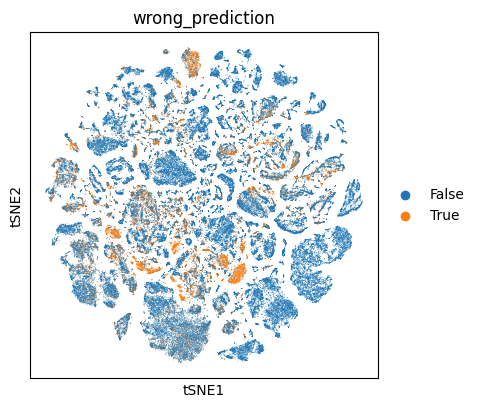

In [16]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata, color='wrong_prediction')